# Lecture 7 – Ensemble Learning and Random Forests

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## Setup

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Wisdom of the crowd

* For a complex problem, aggregating the opinions of tens of thousands of average people can sometimes be more accurate than an expert's opinion. (Real-life example)

* In classification or regression, we can aggregate the predictions of multiple classifiers or regressors to often get much better performance than that of any single classifier/regressor.

* It's called **Ensemble Learning**.


* Example:$1M Netflix Prize competition (2006-2009)

  * Netflix wanted to give $1M to the best team who can predict user ratings for films, based on previous ratings without any other information about the users or films. One condition: better than in-house algorithm.

  * There were several top-performing teams, but no one significantly better than others.

  * Guess which team won the prize.

## Voting Classifiers

* Suppose you have trained a few classifiers on the same training data:
You may have a Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifier, and perhaps a few more.

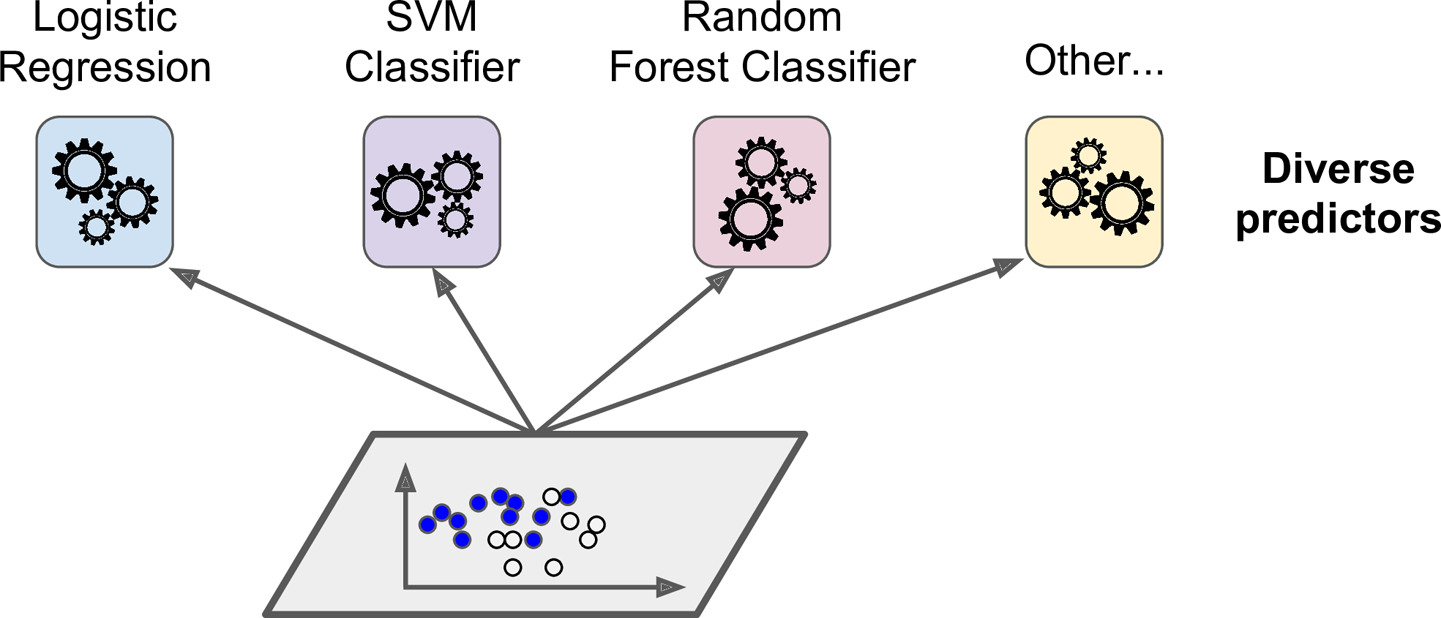

* A simplest ensemble classifier is to take the majority vote of the classes.

* Example. 1, 1, 2, 1, then majority=1

* This majority-vote classifier is called a **hard voting** classifier

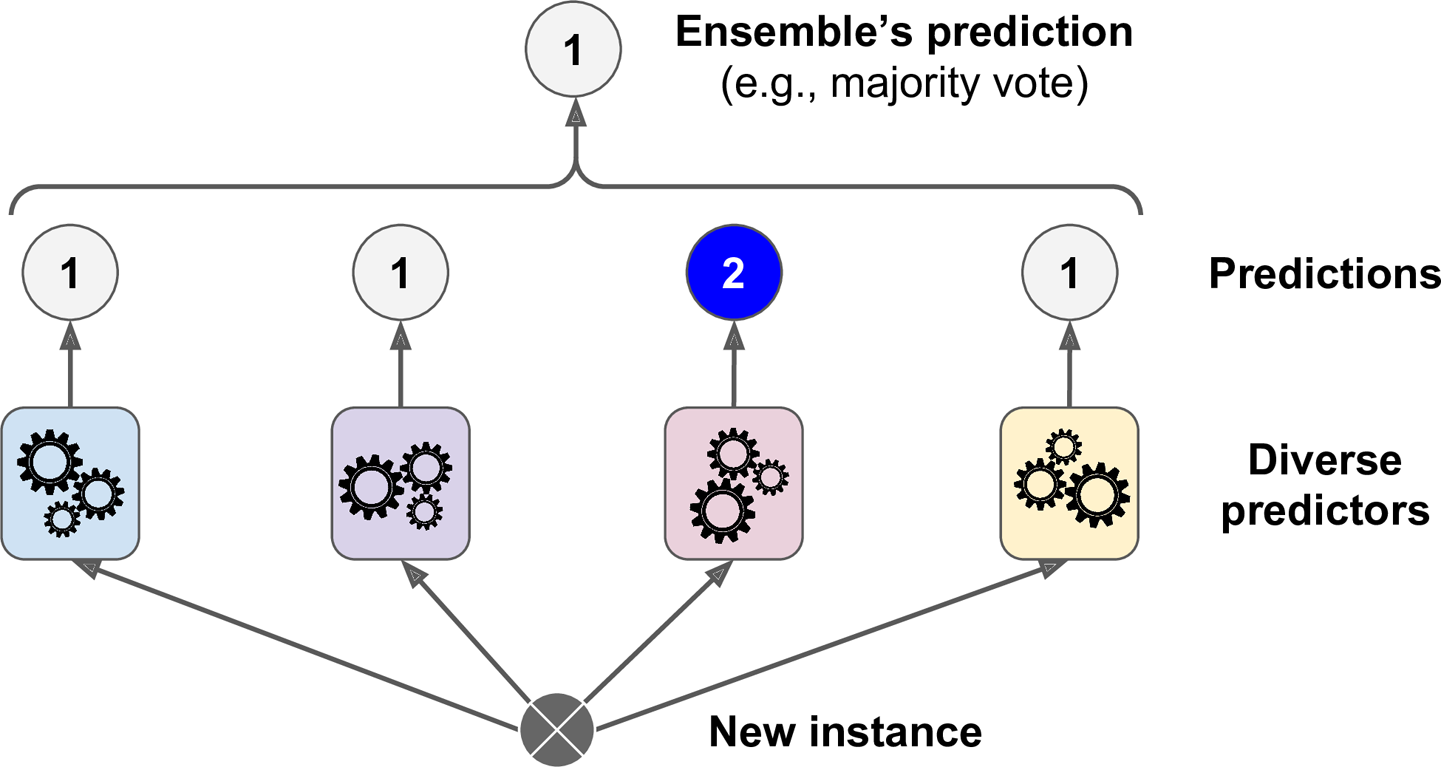

* Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the
best classifier in the ensemble. 

* In fact, even if each classifier is a weak learner (only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy).

* Condition: there are a sufficient number of
weak learners and they are sufficiently diverse.

* Consider the following analogy.

  * Suppose you toss a coin. Assume "heads" is the correct prediction and "tail" is the wrong prediction.
  * You are given a slightly biased coin that has a 51% chance of coming up heads. It's a weak classifier.
  * If you toss it 1,000 times, you will generally get
more or less 510 heads and 490 tails, and hence a majority of heads. 
  * The probability of obtaining a majority of heads after 1,000
tosses is close to 75%. 
    * (optional) Binomial dist: $B(n,k) = C(n,k) p^k (1-p)^{n-k}$
  * With 10,000 tosses, the probability of the majority being heads is 97%.
  * This is due to the law of large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%). 


Let's test this.

In [ ]:
heads_proba = 0.51
max_toss = 10000
n_trial = 10
cumulative_heads_ratio = np.zeros((max_toss,n_trial))
for trial in range(n_trial):
  coin_tosses = (np.random.rand(max_toss) < heads_proba).astype(np.int32)
  cumulative_heads_ratio[:,trial] = np.cumsum(coin_tosses) / np.arange(1, 10001)#.reshape(-1, 1)  
#coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
#cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

In [ ]:
print(cumulative_heads_ratio)
# heads ratio with single toss, double tosses, triple tosses, ..., 10000 tosses

[[1.         1.         0.         ... 1.         0.         0.        ]
 [0.5        1.         0.5        ... 0.5        0.5        0.        ]
 [0.33333333 1.         0.66666667 ... 0.66666667 0.33333333 0.33333333]
 ...
 [0.51930386 0.50470094 0.50860172 ... 0.51040208 0.50640128 0.51190238]
 [0.51935194 0.50475048 0.50865087 ... 0.51045105 0.50645065 0.5119512 ]
 [0.5194     0.5048     0.5087     ... 0.5104     0.5064     0.512     ]]


Saving figure law_of_large_numbers_plot


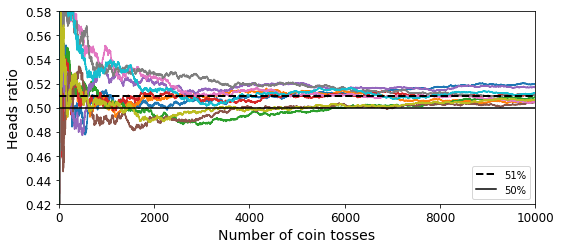

In [ ]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

* Similarly, suppose you build an ensemble containing 10,000 classifiers that are individually correct only 51% of the time

* The majority voted class has up to 97% accuracy! 

* However, this is only true if all classifiers are perfectly independent, making uncorrelated errors.

* Q. The above is not true, why? 

Let's solve the two-moons classification problem with ensemble learning.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [ ]:
## Fit individual classifiers and look at the scores

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


* By default, voting classifier does hard voting (voting="hard").

* Alternative: soft voting. Each classifier could be uncertain/unconfident. So sum up the confidence values instead of tallying up votes.
  * Let confident classifiers contribute more to the final vote.

Soft voting:

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
## Note this line
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging and Pasting

* One way to get a diverse set of classifiers is to use very different training algorithms. 

* Another approach: use the same type for all classifiers but train them on different random subsets of the training set.

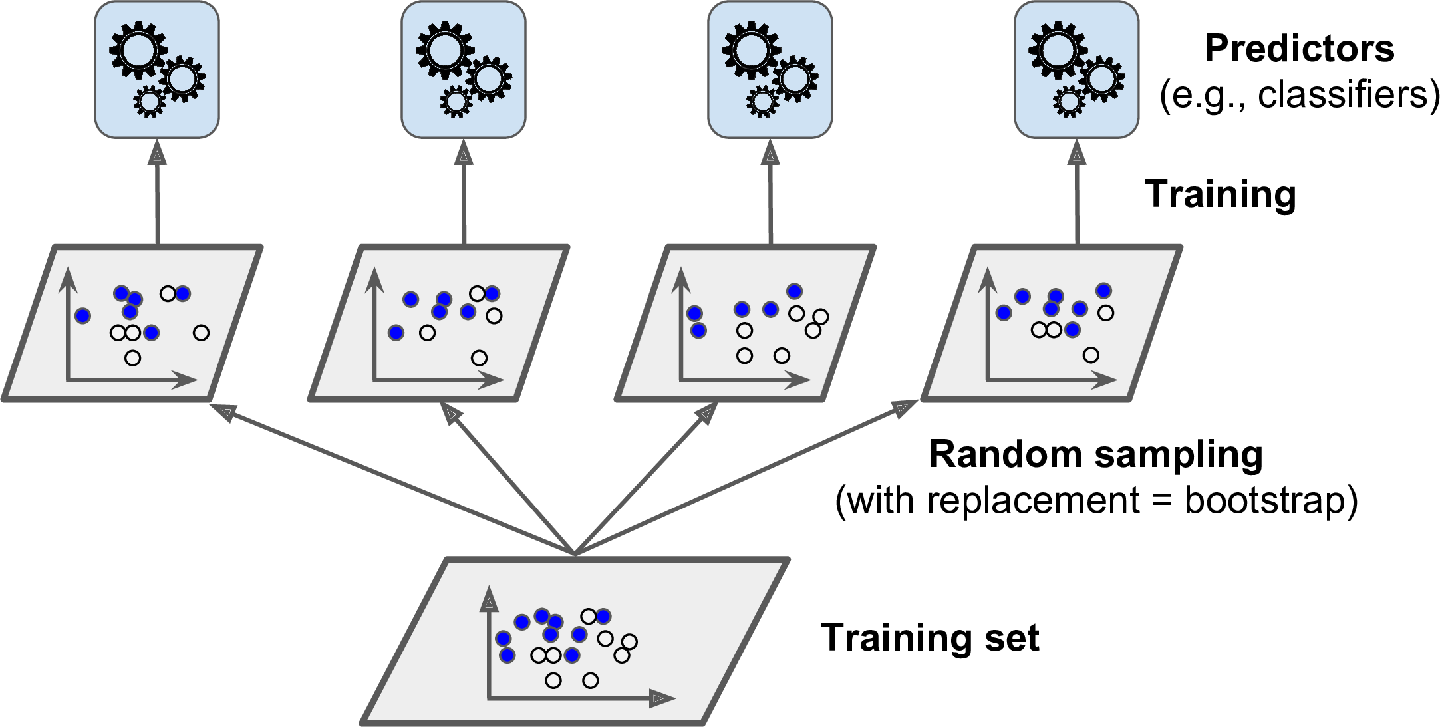

Two closely-related types:
* **bagging** (bootstrap aggregating) : subsampling with replacement for each predictor
* **pasting** : subsampling without replacement for each predictor

Note that each training instance can be sampled several times across multiple predictors. (Or not at all)


* At training time: each predictor is trained on its own training data
* At test time: each predictor makes prediction of the same test point, then the predictions are aggregated
  * Classification: mode (=majority)
  * Regression: average
* Q. Can you see why ensemble methods can be very computationally efficient?

Let's create an ensemble classifier by bagging the decision trees.

Q. What will be a good name for this? (Multiple trees trained on random data subsets)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
# bootstrap=True: Bagging,   bootstrap=False: Pasting
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Decision boudary for Decision Tree (left) versus Bagging

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


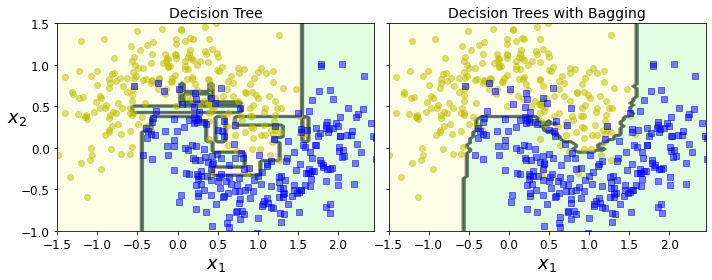

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

* The following figure overlays the decision boundaries of 15 decision trees. 
* Even though each decision tree is imperfect, the ensemble defines a pretty good decision boundary.

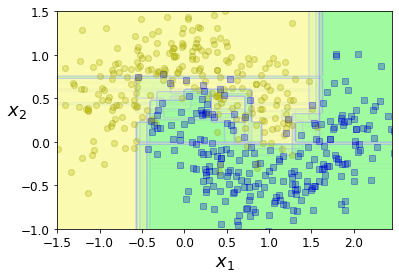

In [ ]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

(Optional) Out-of-Bag evaluation

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

In [ ]:
bag_clf.oob_decision_function_

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

## Random Forests
= ensemble of decision trees

It's a very popular algorithm, so there's a dedicated class in scklearn.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

Q. Which hyperparameter(s) is the above missing?

There are two sets of hyperparameters: one for individual predictors (=decision trees) and another for the ensemble itself.

A Random Forest is equivalent to a bag of decision trees:

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [ ]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

## Feature Importance

* Random Forest has a very useful property.
* It can compute the importance of features:
  * importance: decrease in the impurity after spliting with that feature
* Let's test it with the Iris dataset.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


* If the data is an image, than each feature is a pixel
  * We can compute the importance of each pixel!
  * Can you imagine what it would be like?

Let's fit a Random Forest to the MNIST dataset.

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


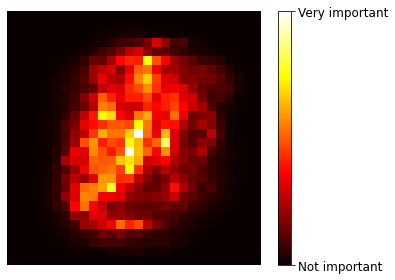

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## Boosting

* Boosting: any Ensemble method that combines several weak predictors into a strong predictor. 
* It's not the same as Bagging (=boostrap aggregating) such as Random Forest
* Boosting algorithm is trained sequentially, one weak predictor at a time. (Cf. Bagging)

* Two Popular Boosting algorithms are:
  * AdaBoost (=Adaptive Boosting)
  * Gradient Boosting

## AdaBoost

* Predictors are learned sequentially.
* A new predictor tries to to correct its predecessor by paying a bit more attention to the training instances that the predecessor misclassifed or underfitted.
* That is, make new predictors focus more and more on the hard cases. 

* Consider the regression example.
* At each iteration, the loss is NOT the simple average MSE
  * $\frac{1}{m}\sum_i |y_i - f(x_i)|^2$
  but instead the loss is a weighted average MSE
  * $\frac{1}{m}\sum_i \beta_i |y_i - f(x_i)|^2$
  where $\beta_i$ is the weight of the i-th example.
* The weight $\beta_i$ is chosen to be small (~0) if the $i$-th example was predicted well by the predecessors.
* The weight $\beta_i$ is are chosen to be large (~1) if the $i$-the example was underfitted by the predecessors.



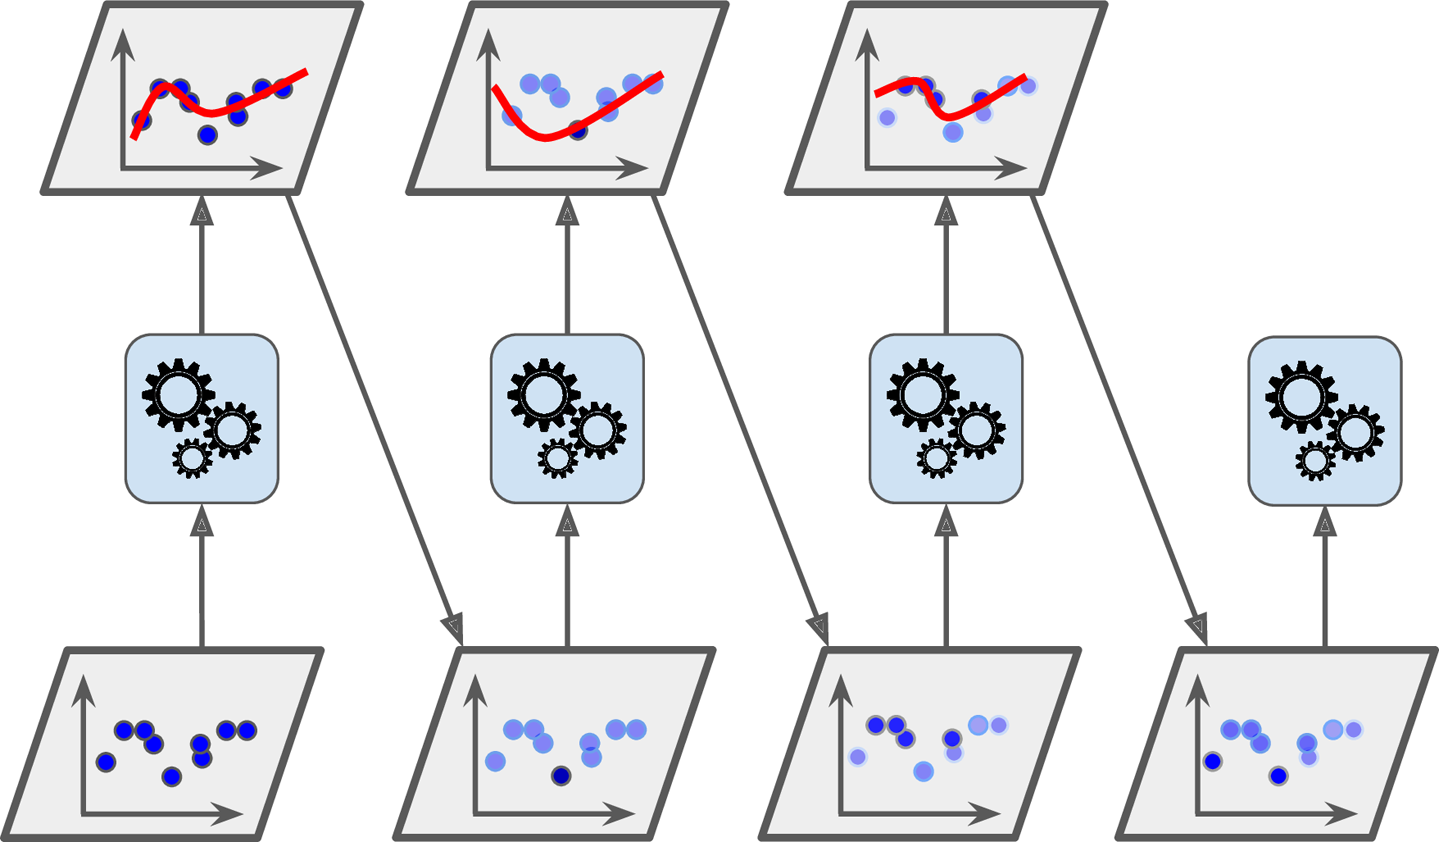

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

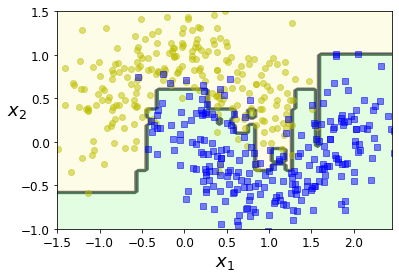

In [ ]:
plot_decision_boundary(ada_clf, X, y)

* You can also implement AdaBoost manually (without importing the AdaBoostClassifier class)
* Suppose you use SVC with RBF kernel as weak classifiers.
* Let's plot the decision boundaries of each weak classifier.

Saving figure boosting_plot


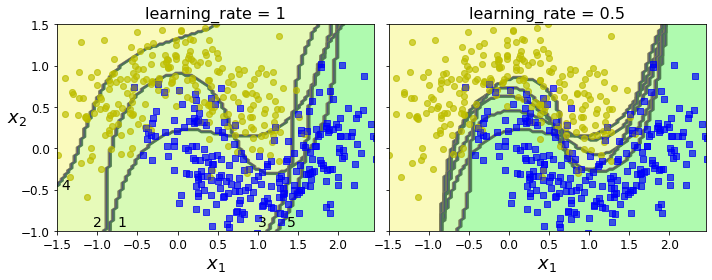

In [ ]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

* The final predictor is the (weighted) majority vote of the weak predictors:
  * $\hat{y} = argmax_k \sum_{j=1}^N \alpha_j I[\hat{y}_j(x)=k]$
* The weight of each predictor $\alpha_j$ is high if the $j$-th weak predictor had a high training set accuracy.
* The weight of each predictor $\alpha_j$ is low if the $j$-th weak predictor had a low training set accuracy.
* This weight $\alpha_j$ is totally different from the weight $\beta_i$ of the i-th example during training.



## Gradient Boosting

* Similar to AdaBoost: sequentially add a predictor to the ensemble, each one correcting its predecessor. 
* Different from AdaBoost, Gradient Boosting tries to fit the new predictor to the residual errors made by the previous predictor.

Let create a simple quadratic dataset:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

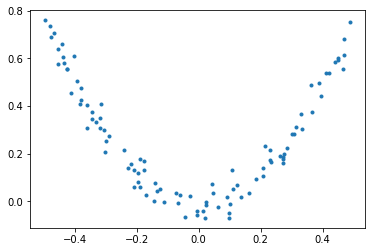

In [ ]:
plt.plot(X, y,'.')

Now let's train a decision tree regressor on this dataset:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Fit the 2nd regressor to the residual error.

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Fit the 3rd regressor to the residual error.

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Let's create a test exmple.

In [ ]:
X_new = np.array([[0.8]])

The final strong regressor is the sum of the regressors.

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
y_pred

array([0.75026781])

* Here's a nice visualization of the Gradient Boosting.
* 1st first predictor (top left) is trained normally
* Each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals
* The right column shows the resulting ensemble’s predictions.

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


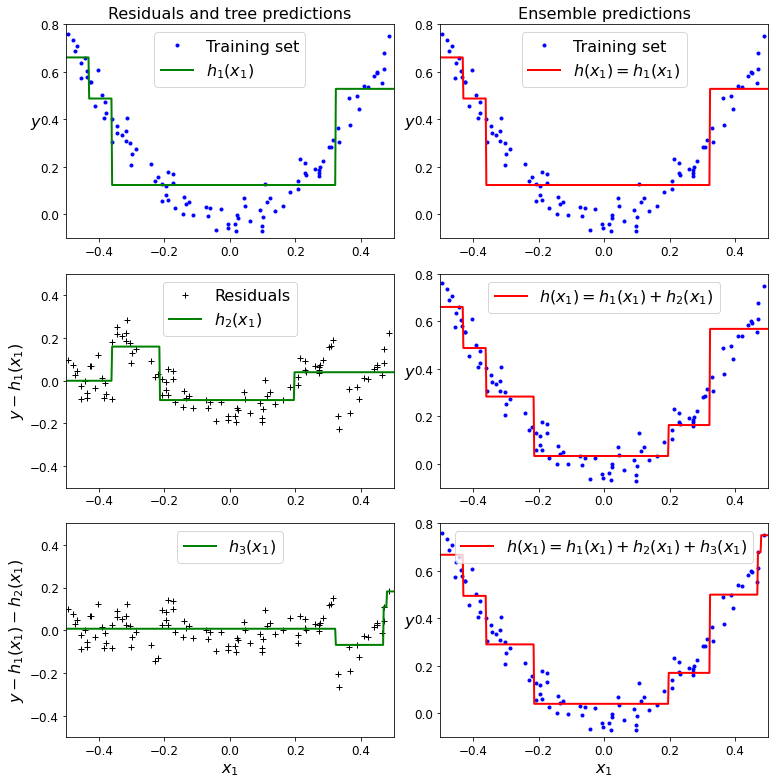

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

Of course, we don't need to manually train the regressors.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

Q. Which hyperparmaters/arguments are missing in the construction of the GradientBoostingRegressor object?

* How important is the n_estimators?

* GBRT with not enough predictors (left) and too many (right):

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


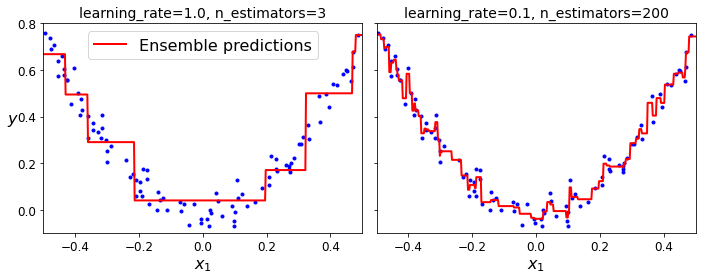

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

* The optimal number of predictors (=decision trees) can be chosen by early stopping.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

Tuning the number of trees using early stopping:

In [ ]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


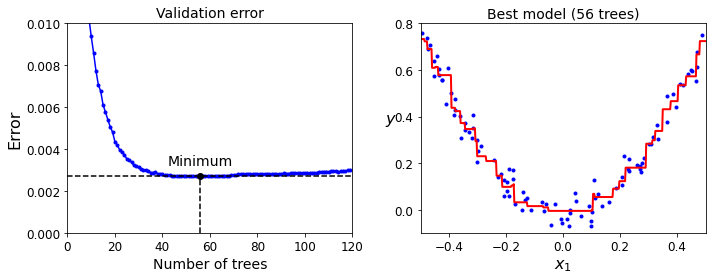

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

Early stopping with some patience (interrupts training only after there's no improvement for 5 epochs):

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [ ]:
print(gbrt.n_estimators)

61


In [ ]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


## XGBoost
* It is a variant of Gradient Boosting that is efficient to train and works particulary well. 
* It has won a lot of ML challenges among non-Deep Learning methods.

In [ ]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [ ]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.00400040950714611


In [ ]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129

Validation MSE: 0.0026308690413069744


In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

76.1 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

20.8 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Stacking

is short for stacked generalization.

Q. In ensemble learning, do I always have to take the majority votes (for classification) and the average (for regression)? 

A. What if we "learn" to combine the predictions to make the final prediction?

This final predictor is called a blender or meta-learer.

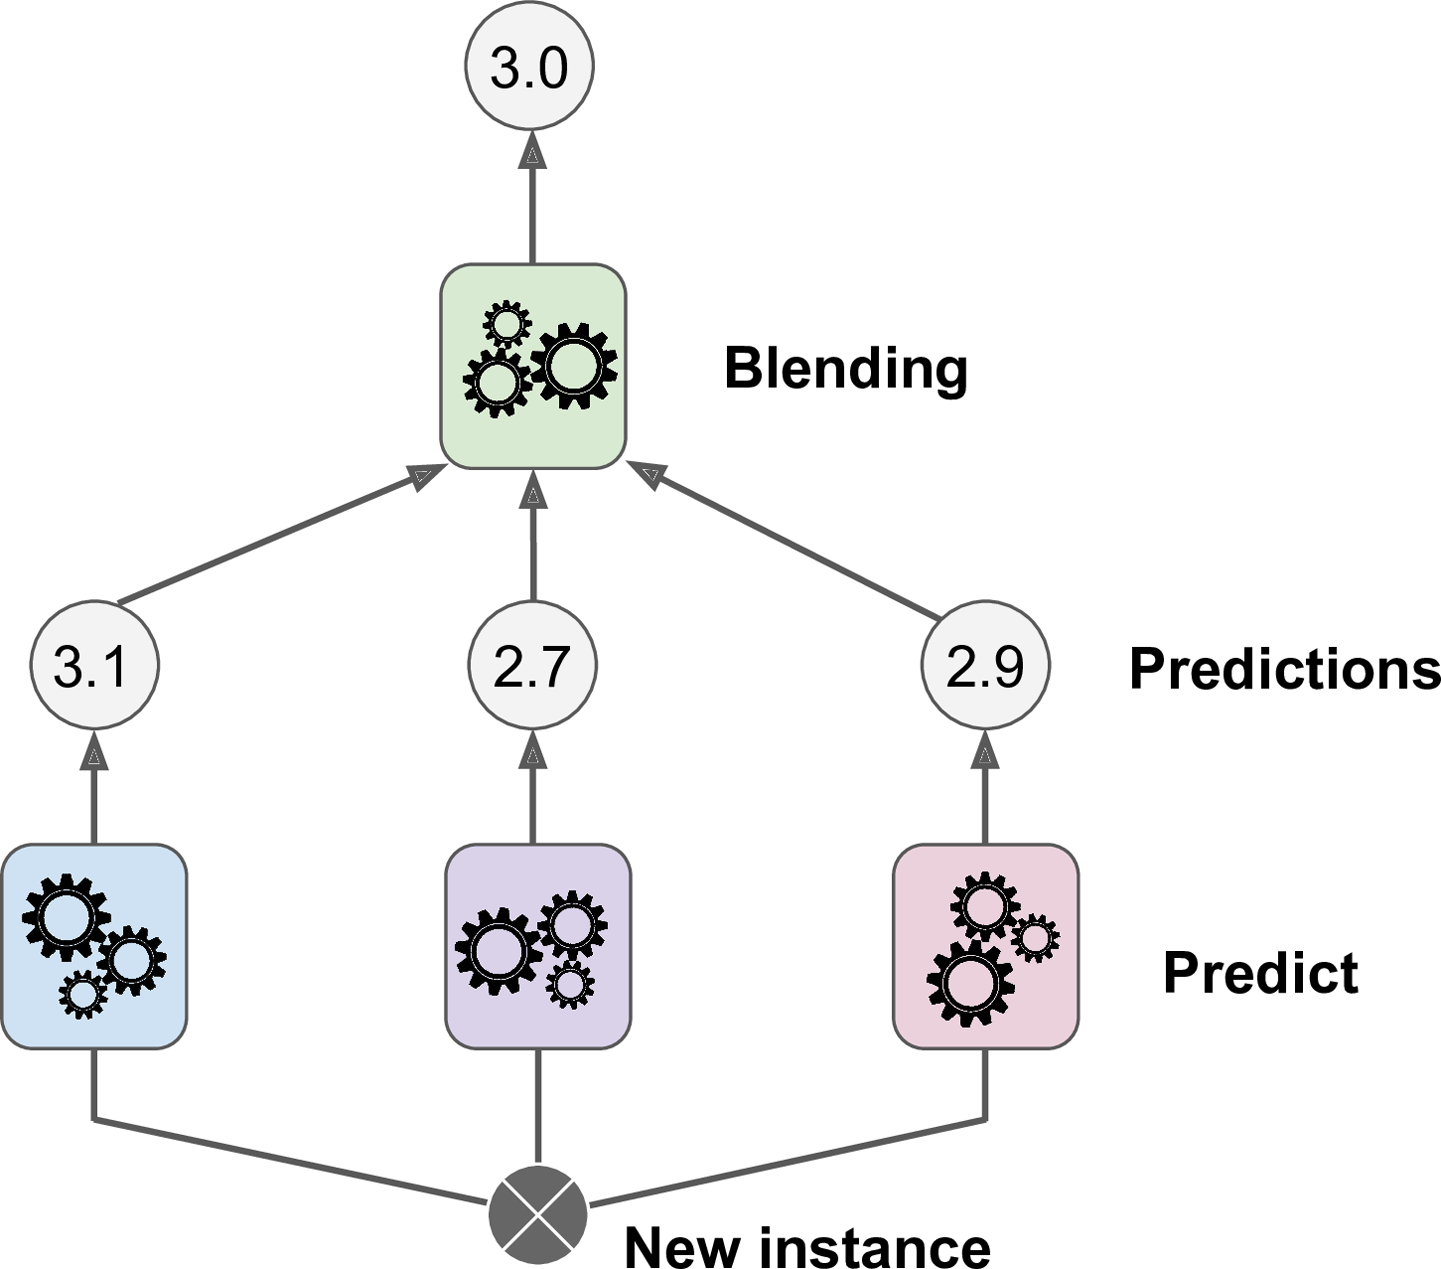

* How do we train the blender then?
* It's done in two steps:
  * First, split the training set into two.
  * Second, use the left set to train the predictors.


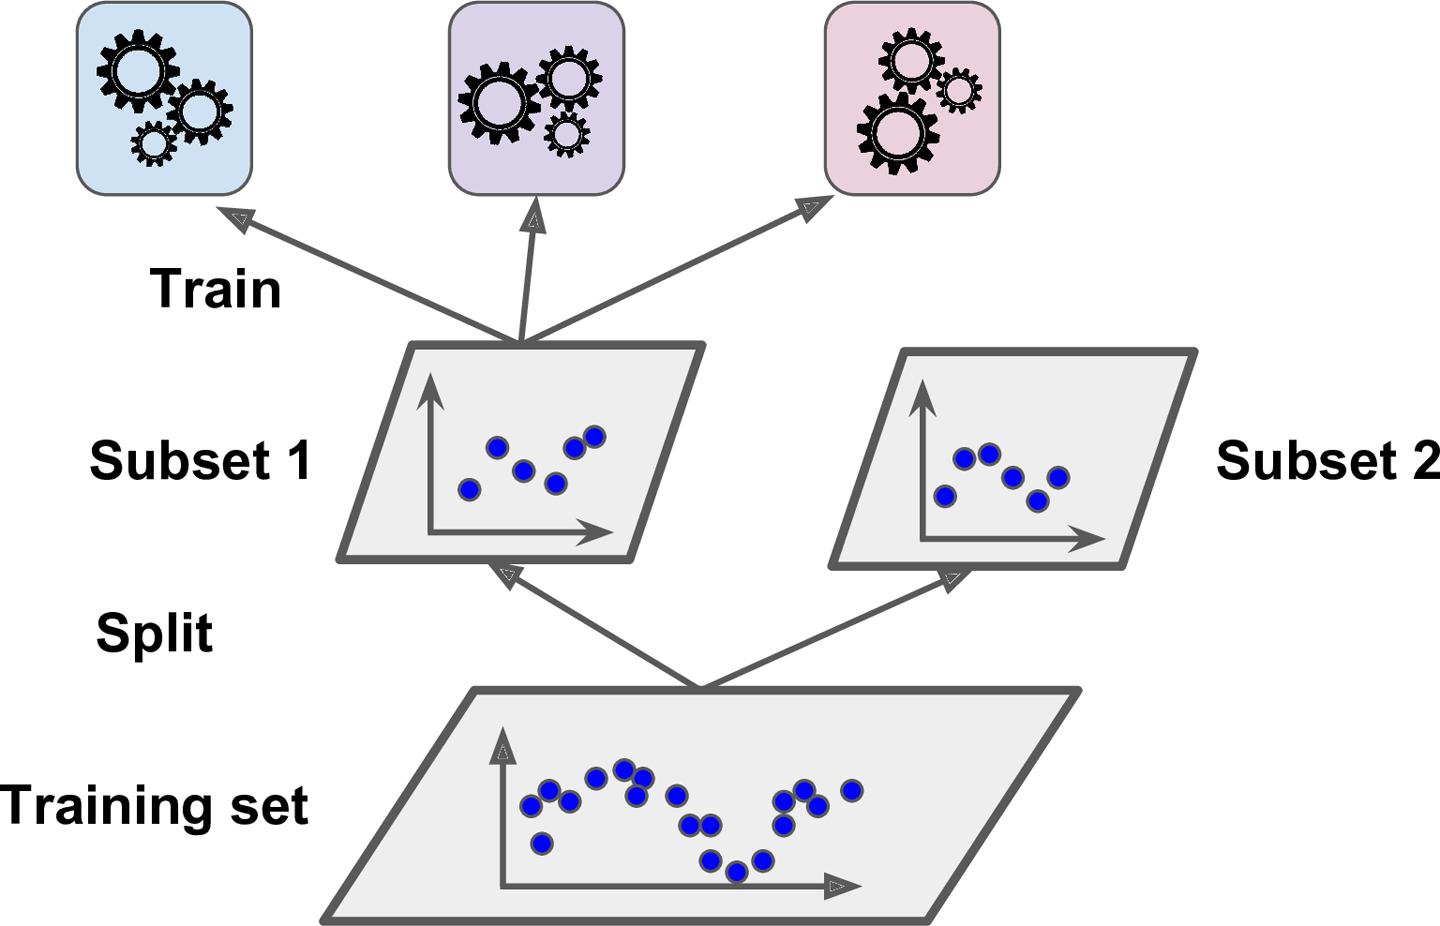

* 
  *  

    * Third, make predictions on the right set.
    * Fourth, use the predictions as training set for the blender.


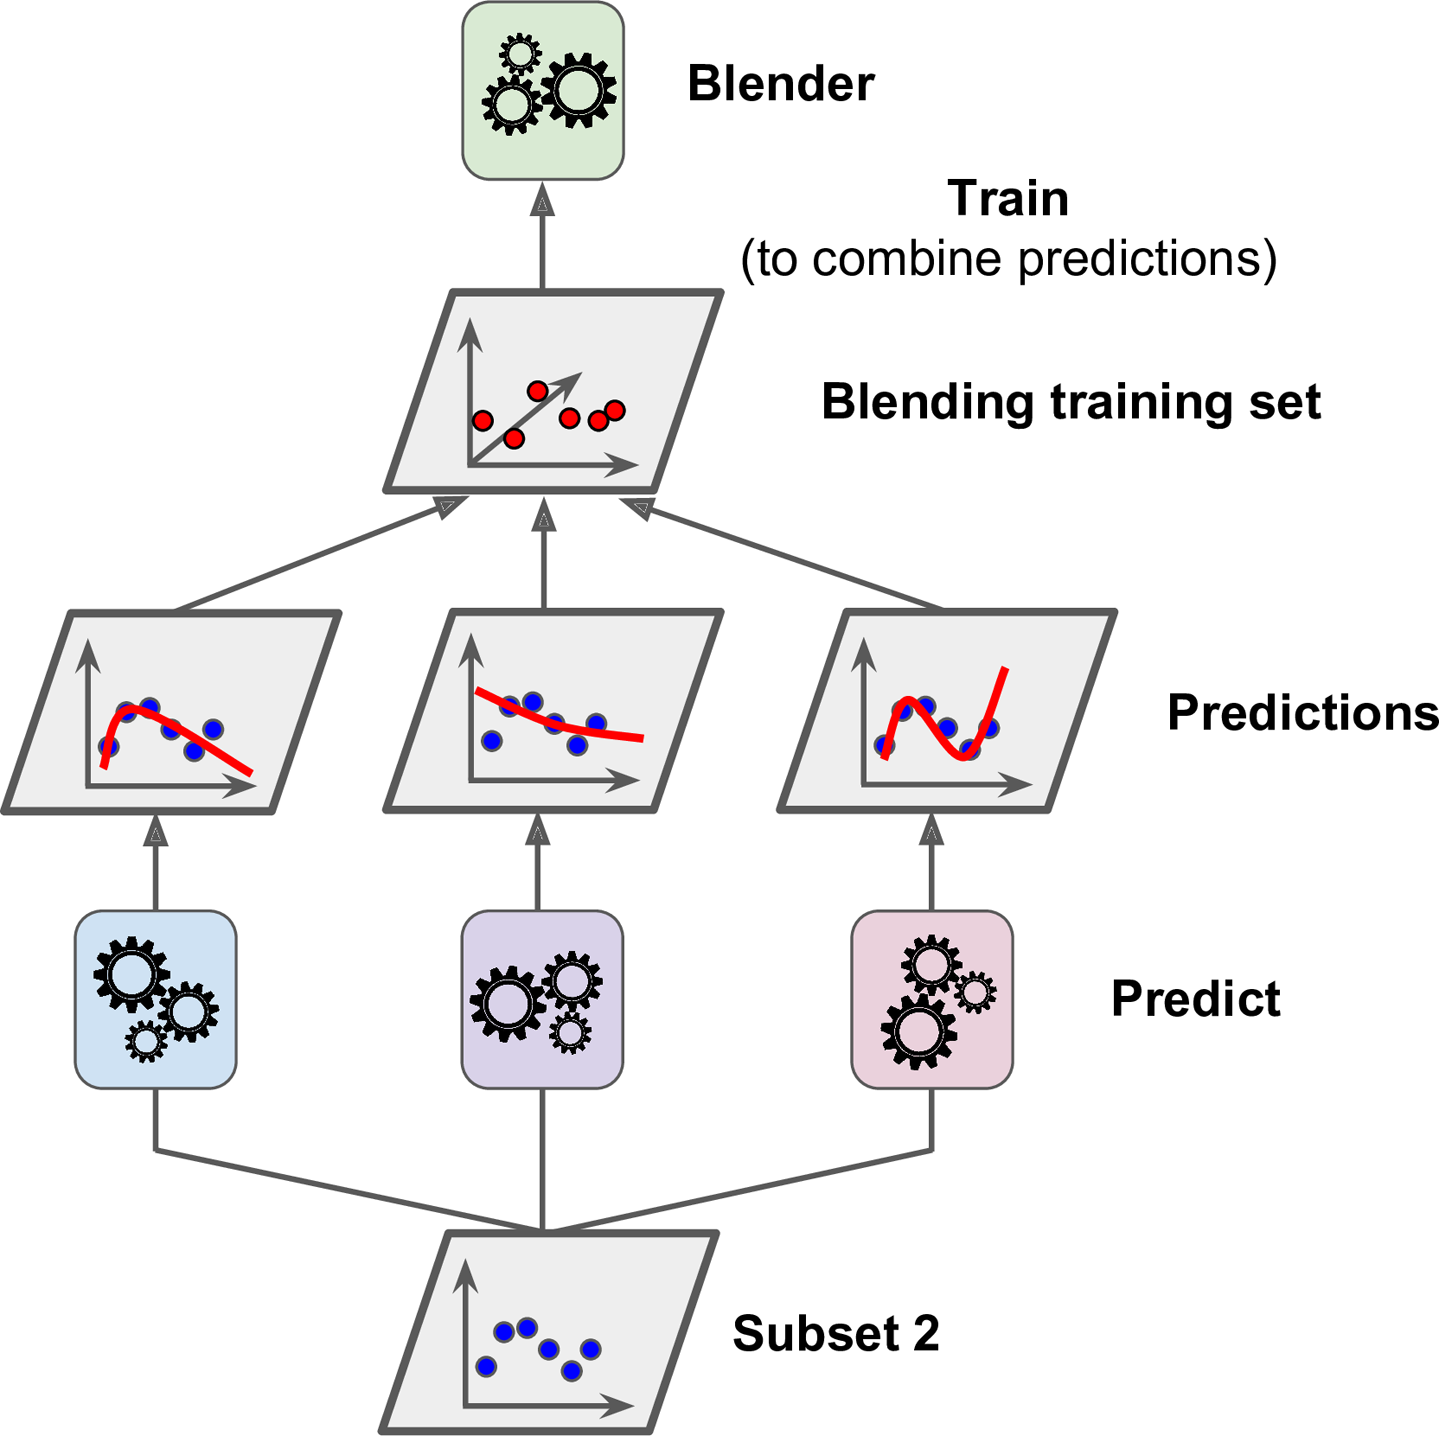

* In fact we can have multiple blenders, and use their predictions to train the next-level blenders (or "blender of blender").  

* In this way, we can stack many layers of blenders.

* Prediction for a new test example:


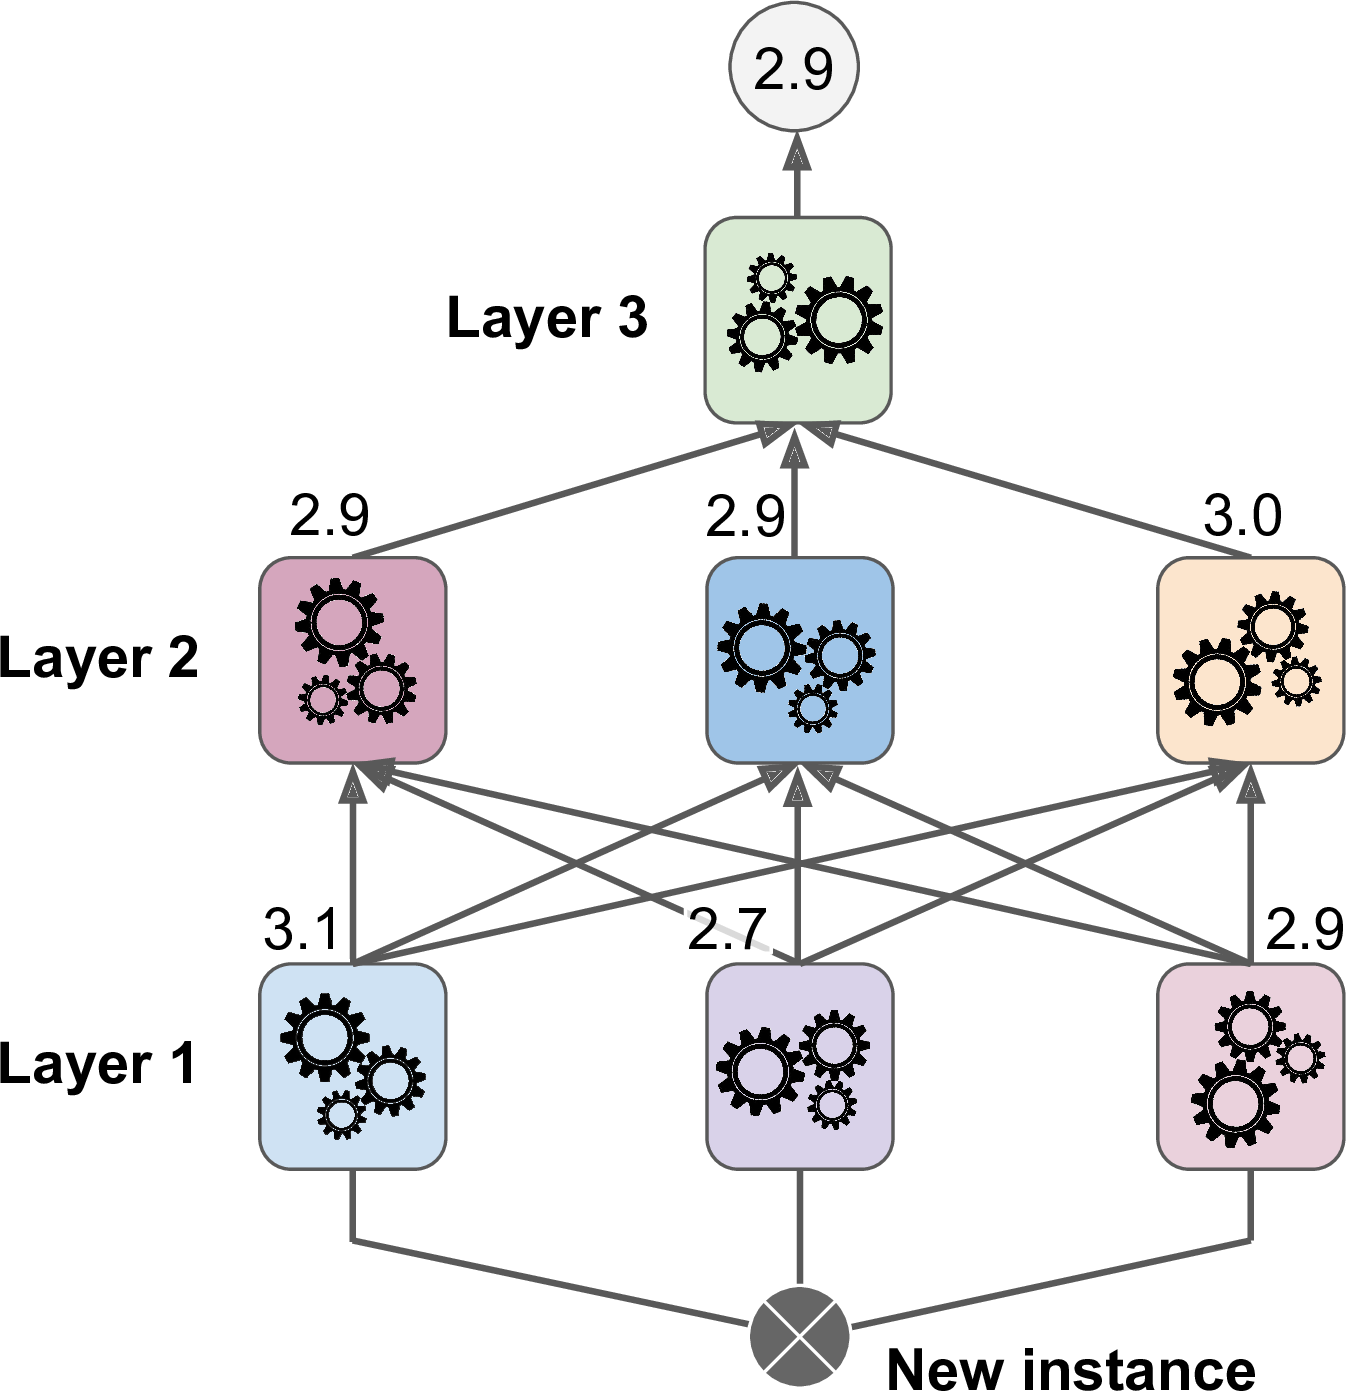

* Stacking isn't used as commonly as other ensemble methods, but it shares some ideas with Neural Networks that we'll see later.